# Entreno en 2500 pruebo en 20mil

In [1]:
import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

## Funcion de ayuda

In [9]:
def run_test(clf, tile, X_columns, y_column):
    X_test = tile[X_columns].values
    y_test = tile[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    print metrics.classification_report(y_test, predictions)
    
    return Container({
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})

## Train 2.5K

In [3]:
sample = pd.read_pickle("data/ogle3_only/scaled/s2_5k.pkl")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 2.5k

In [5]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_2_5k.pkl"))

In [6]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [7]:
clf_small = RandomForestClassifier(n_estimators=500, criterion="entropy")
clf_small.fit(train.b278[X_columns].values, train.b278.cls.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [10]:
result_small = run_test(clf_small, test.b261, X_columns, "cls")

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19972
          1       0.72      0.88      0.79       221

avg / total       1.00      0.99      1.00     20193



## Train 5K

In [11]:
sample = pd.read_pickle("data/ogle3_only/scaled/s5k.pkl")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
train = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

Reescalamos la muestra de 20k con media y desvio del de 5k

In [12]:
skl = pickle.load(open("data/ogle3_only/scalers/scaler_5k.pkl"))

In [13]:
sample = pd.read_pickle("data/ogle3_only/nonull/s20k.pkl")

sample[X_columns] = skl.transform(sample[X_columns])

sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])
sample["cls"] = sample.vs_type.apply(lambda x: 0 if x == "" else 1)

grouped = sample.groupby("tile")
test = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})

del grouped, sample

In [14]:
clf_med = RandomForestClassifier(n_estimators=500, criterion="entropy")
clf_med.fit(train.b278[X_columns].values, train.b278.cls.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [15]:
result_med = run_test(clf_med, test.b261, X_columns, "cls")

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     19972
          1       0.86      0.84      0.85       221

avg / total       1.00      1.00      1.00     20193



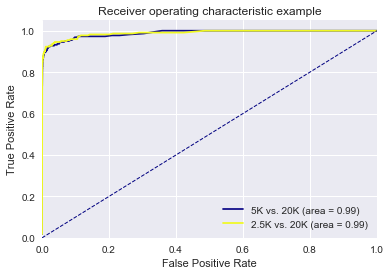

In [16]:
roc({"5K vs. 20K": result_med, "2.5K vs. 20K": result_small})